In [1]:
from imagenheap import ImagenHeap
from imagenheap.utilities.logger_config import get_logger

logger = get_logger()
logger.intercept_package_logs('segment')

2024-04-10 07:38:26 PM INFO Intercepting logs from package: segment


In [2]:
ih = ImagenHeap()

# Load the configuration using a config file
ih.load_config("/workspace/ImagenHeap/configs/imagenheap/local_files.yml")

Loading dataset: /workspace/ImagenHeap/datasets/fashion_people_detection/images/train


Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

In [3]:
# # overide any configurations using the add_args method
# ih.add_args("detect").text_prompt = ["person", "glasses"]

In [4]:
# get the results
results = ih.run()

Progress:   0%|          | 0/2 [00:00<?, ?it/s]

final text_encoder_type: bert-base-uncased


Running Detect:   0%|          | 0/100 [00:00<?, ?it/s]

Running Segment:   0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
# ih.format_results(include_polygons=False)

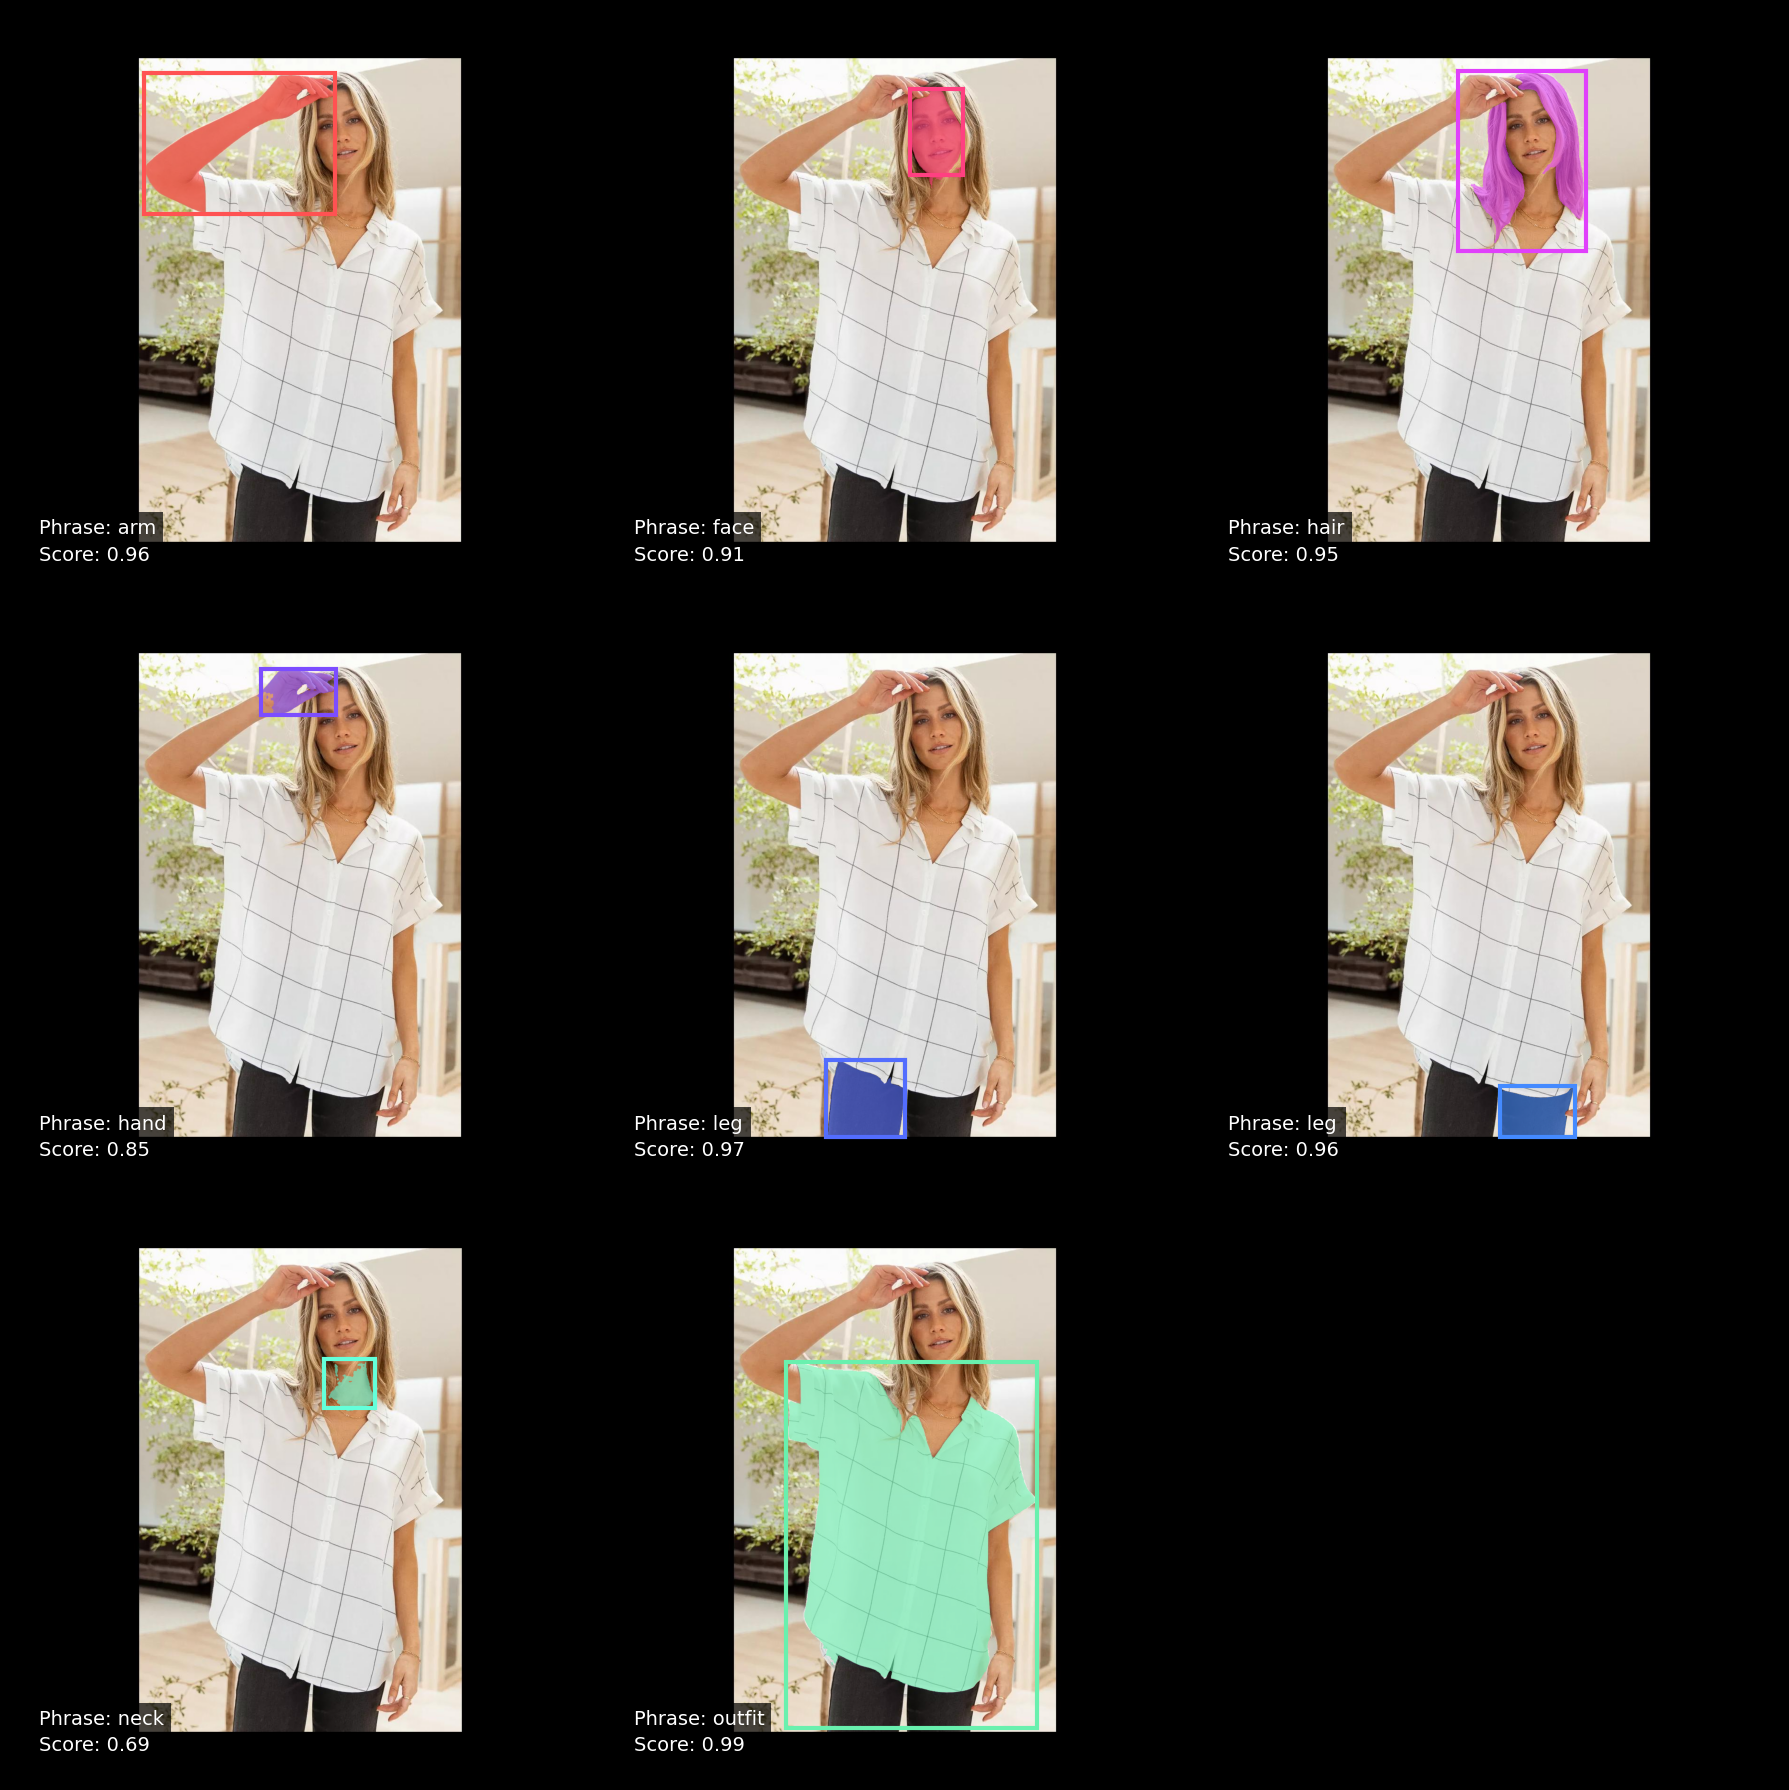

In [11]:
ih.visualize()